In [1]:
# KnockoffNet Attack on CIFAR10
# import packages
import torch
import timm
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary


In [2]:
# settings
use_cuda = True
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
print(device)

batch_size = 1000
epochs = 2 # 1K X 50 X 2 = 100K
learning_rate = 0.1

mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

cuda


In [3]:
# dataset loader
data_path = '../data/'

cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32), antialias=True),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean, std)
])

train_data_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=cifar10_transform)
test_data_cifar10 = datasets.CIFAR10(data_path, train=False, download=True, transform=cifar10_transform)
train_data_mnist = datasets.MNIST(data_path, train=True, download=True, transform=mnist_transform)
test_data_mnist = datasets.MNIST(data_path, train=False, download=True, transform=mnist_transform)

len(train_data_cifar10), len(test_data_cifar10), len(train_data_mnist), len(test_data_mnist)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000, 60000, 10000)

In [4]:
# print dataset status function
def print_stats(dataset):
  imgs = np.array([img.numpy() for img, _ in dataset])
  print(f'shape: {imgs.shape}')
    
  min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
  min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
  min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

  max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
  max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
  max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

  mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
  mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
  mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

  std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
  std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
  std_b = np.std(imgs, axis=(2, 3))[:, 2].std()
    
  print(f'min: {min_r, min_g, min_b}')
  print(f'max: {max_r, max_g, max_b}')
  print(f'mean: {mean_r, mean_g, mean_b}')
  print(f'std: {std_r, std_g, std_b}')

In [5]:
train_loader_cifar10 = torch.utils.data.DataLoader(train_data_cifar10, batch_size=batch_size, shuffle=False)
test_loader_cifar10 = torch.utils.data.DataLoader(test_data_cifar10, batch_size=batch_size, shuffle=False)

print_stats(train_data_cifar10)

shape: (50000, 3, 32, 32)
min: (-1.0, -1.0, -1.0)
max: (1.0, 1.0, 1.0)
mean: (-0.017200625, -0.035683163, -0.10693816)
std: (0.121056795, 0.122249946, 0.13529024)


In [6]:
train_loader_mnist = torch.utils.data.DataLoader(train_data_mnist, batch_size=batch_size, shuffle=False)
test_loader_mnist = torch.utils.data.DataLoader(test_data_mnist, batch_size=batch_size, shuffle=False)

print_stats(train_data_mnist)

shape: (60000, 3, 32, 32)
min: (-1.0, -1.0, -1.0)
max: (1.0, 1.0, 1.0)
mean: (-0.7382972, -0.7382972, -0.7382972)
std: (0.09636482, 0.09636482, 0.09636482)


In [7]:
#load pretrained model(vitcim model)
victim_model = timm.create_model("resnet18", pretrained=False)

# override model
victim_model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
victim_model.maxpool = nn.Identity()  # type: ignore
victim_model.fc = nn.Linear(512,  10)

victim_model.load_state_dict(
            torch.hub.load_state_dict_from_url(
                      "https://huggingface.co/edadaltocg/resnet18_cifar10/resolve/main/pytorch_model.bin",
                       map_location="cuda", 
                       file_name="resnet18_cifar10.pth",
             )
)

victim_model.to(device)
summary(victim_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
          Identity-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
          Identity-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
       BasicBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [8]:
# define attacker model
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # set bias=False in Conv2d since BatchNorm2d has bias already
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping. when dimention of input and output is same, shortcut is used.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

attacker_model = resnet18().to(device)

summary(attacker_model, (3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [9]:
# test query
victim_model.eval()
query = torch.rand(1, 3, 32, 32).to(device)
output = victim_model(query)

softmax = nn.Softmax(dim=1)(output)
onehot = torch.zeros_like(output)

print("Softmax output: ", softmax)
print("One-hot output: ", onehot)

Softmax output:  tensor([[4.9695e-04, 1.8704e-05, 8.3069e-02, 7.8080e-03, 2.9288e-02, 3.0896e-05,
         8.7905e-01, 1.1706e-05, 4.1665e-05, 1.8797e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
One-hot output:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')


In [10]:
# define loss function (criterion) and optimizer
optimizer = optim.Adam(attacker_model.parameters())
criterion = nn.BCELoss().to(device)

plot_data = {
    "cifar10_softmax": [],
    "cifar10_onehot": [],
    "mnist_softmax": [],
    "mnist_onehot": []
}

# attack
def knockoff_attack(data_loader, test_loader, is_softmax, plot_data):
    """
    This function performs the knockoff attack on the victim model.
    """
    for epoch in range(epochs):
        for i, data in enumerate(data_loader):
            victim_model.eval()
            attacker_model.train()

            inputs, labels = data
            inputs = inputs.to(device)

            # get victim output
            outputs = victim_model(inputs)

            # train attacker model
            attacker_outputs = attacker_model(inputs)
            attacker_outputs = nn.Softmax(dim=1)(attacker_outputs)

            # calculate loss
            if is_softmax:
                outputs = nn.Softmax(dim=1)(outputs)
            else:
                outputs = torch.zeros_like(outputs).scatter_(1, torch.argmax(outputs, dim=1, keepdim=True), 1)

            loss = criterion(attacker_outputs, outputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # check accuracy every 1000 queries (batch_size = 1000)
            query_cnt = epoch * batch_size * len(data_loader) + (i + 1) * batch_size
            print('Epoch: %d, Query: %d, loss: %.3f' % (epoch + 1, query_cnt, loss.item()))

            # check accuracy
            test_attacker_model(test_loader, query_cnt, plot_data)
        # lr_scheduler.step(loss.item())

    print('Finished Training') 

# test attacker model

def test_attacker_model(data_loader, query_size, plot_data):
    """
    This function tests the attacker model on the test dataset.
    """
    attacker_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            attacker_outputs = attacker_model(images)

            _, predicted = torch.max(attacker_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('query: %d, Accuracy: %.3f %%' % (query_size, 100 * correct / total))
        plot_data.append([query_size, 100 * correct / total])


In [11]:
# run attack

# CIFAR10 - Softmax
knockoff_attack(train_loader_cifar10, test_loader_cifar10, True, plot_data["cifar10_softmax"])
torch.save(attacker_model.state_dict(), "../model/knockoff_attack_cifar10_softmax.pt")

# CIFAR10 - One-hot
attacker_model = resnet18().to(device)
optimizer = optim.Adam(attacker_model.parameters())
criterion = nn.BCELoss().to(device)
knockoff_attack(train_loader_cifar10, test_loader_cifar10, False, plot_data["cifar10_onehot"])
torch.save(attacker_model.state_dict(), "../model/knockoff_attack_cifar10_onehot.pt")

# MNIST - Softmax
attacker_model = resnet18().to(device)
optimizer = optim.Adam(attacker_model.parameters())
criterion = nn.BCELoss().to(device)
knockoff_attack(train_loader_mnist, test_loader_mnist, True, plot_data["mnist_softmax"])
torch.save(attacker_model.state_dict(), "../model/knockoff_attack_mnist_softmax.pt")

# MNIST - One-hot
attacker_model = resnet18().to(device)
optimizer = optim.Adam(attacker_model.parameters())
criterion = nn.BCELoss().to(device)
knockoff_attack(train_loader_mnist, test_loader_mnist, False, plot_data["mnist_onehot"])
torch.save(attacker_model.state_dict(), "../model/knockoff_attack_mnist_onehot.pt")


Epoch: 1, Query: 1000, loss: 0.331
query: 1000, Accuracy: 15.810 %
Epoch: 1, Query: 2000, loss: 0.310
query: 2000, Accuracy: 17.520 %
Epoch: 1, Query: 3000, loss: 0.290
query: 3000, Accuracy: 17.480 %
Epoch: 1, Query: 4000, loss: 0.282
query: 4000, Accuracy: 18.000 %
Epoch: 1, Query: 5000, loss: 0.272
query: 5000, Accuracy: 17.310 %
Epoch: 1, Query: 6000, loss: 0.267
query: 6000, Accuracy: 14.360 %
Epoch: 1, Query: 7000, loss: 0.259
query: 7000, Accuracy: 18.330 %
Epoch: 1, Query: 8000, loss: 0.250
query: 8000, Accuracy: 19.250 %
Epoch: 1, Query: 9000, loss: 0.254
query: 9000, Accuracy: 19.480 %
Epoch: 1, Query: 10000, loss: 0.242
query: 10000, Accuracy: 20.290 %
Epoch: 1, Query: 11000, loss: 0.243
query: 11000, Accuracy: 19.580 %
Epoch: 1, Query: 12000, loss: 0.241
query: 12000, Accuracy: 19.960 %
Epoch: 1, Query: 13000, loss: 0.240
query: 13000, Accuracy: 20.610 %
Epoch: 1, Query: 14000, loss: 0.235
query: 14000, Accuracy: 18.700 %
Epoch: 1, Query: 15000, loss: 0.237
query: 15000, Ac

In [12]:
# save plot data 
np.save('plot_data.npy', plot_data)

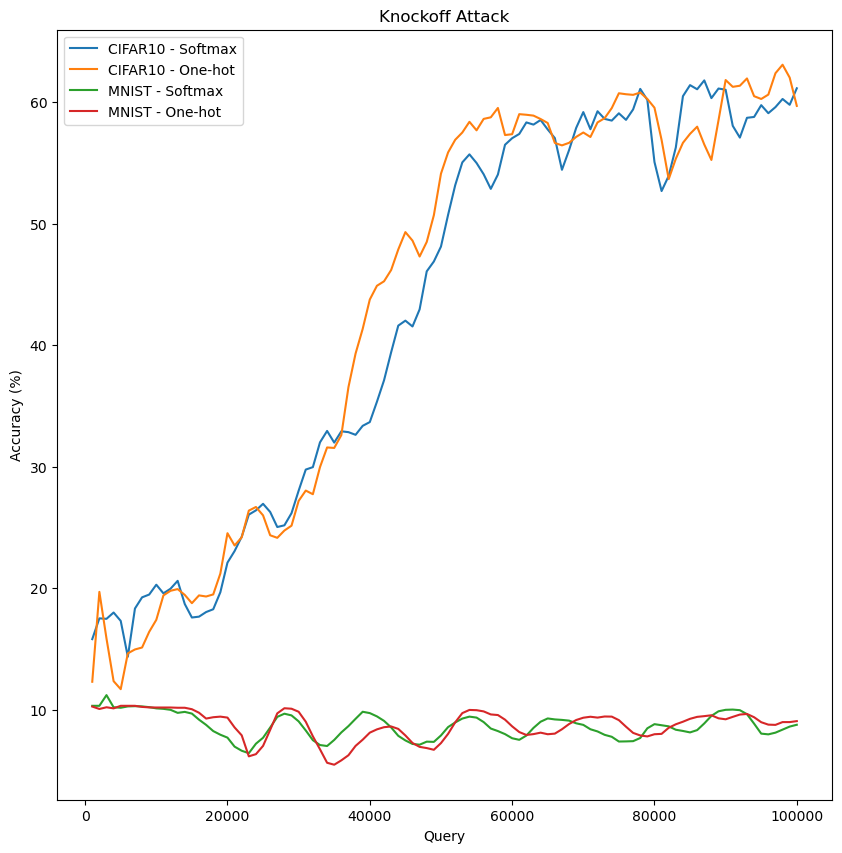

In [22]:
# plot
def get_x_y(data):
    x = [x[0] for x in data if x[0] <= 100000]
    y = [x[1] for x in data if x[0] <= 100000]
    return x, y

plt.figure(figsize=(10, 10))
plt.plot(get_x_y(plot_data["cifar10_softmax"])[0], get_x_y(plot_data["cifar10_softmax"])[1], label="CIFAR10 - Softmax")
plt.plot(get_x_y(plot_data["cifar10_onehot"])[0], get_x_y(plot_data["cifar10_onehot"])[1], label="CIFAR10 - One-hot")
plt.plot(get_x_y(plot_data["mnist_softmax"])[0], get_x_y(plot_data["mnist_softmax"])[1], label="MNIST - Softmax")
plt.plot(get_x_y(plot_data["mnist_onehot"])[0], get_x_y(plot_data["mnist_onehot"])[1], label="MNIST - One-hot")
plt.legend()
plt.xlabel("Query")
plt.ylabel("Accuracy (%)")
plt.title("Knockoff Attack")
plt.savefig("../assets/knockoff_attack.png")

plt.show()